##### Imports

In [1]:
"""
Focus on human data primarily on hIVSCC-MET for AIBS
-Tree call for Mouse
-Seurat prediction score for Human

*Make a scatter plot NMS score vs Seurat prediction score (Add n values)
1) RNA amp pass
2) RNA amp fail 


*Make same plot as Agata with barplot, tree call option with counts for RNA_amp, NMS fail and options
Collaborators have hIVSCC-MET and hIVSCC-METx
"""

'\nFocus on human data primarily on hIVSCC-MET for AIBS\n-Tree call for Mouse\n-Seurat prediction score for Human\n\n*Make a scatter plot NMS score vs Seurat prediction score (Add n values)\n1) RNA amp pass\n2) RNA amp fail \n\n\n*Make same plot as Agata with barplot, tree call option with counts for RNA_amp, NMS fail and options\nCollaborators have hIVSCC-MET and hIVSCC-METx\n'

In [104]:
import pandas as pd
import numpy as np
import csv
import logging
import os
from scipy.stats import pearsonr

from functions.temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df, create_container_df

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(context = "notebook", style = "ticks", font="verdana") # font_scale = 1.35)
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

##### Paths

In [3]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/analysis_scripts/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "plot/")
path_shiny_human = os.path.join(csv_path, "current_shiny_human.csv")

##### Start Code

In [4]:
fields_shiny = ["cell_name", "cell_specimen_project", "Norm_Marker_Sum.0.4_label",
                "marker_sum_norm_label", "rna_amplification_pass_fail",
                "percent_cdna_longer_than_400bp", "amplified_quantity_ng", "sample_id", 
                "Tree_call", "seurat_prediction_score_label"]

shiny_dict = {"Norm_Marker_Sum.0.4_label" : "NMS Pass/Fail",
              "rna_amplification_pass_fail" : "RNA amp Pass/Fail",
              "marker_sum_norm_label": "NMS score",
              "percent_cdna_longer_than_400bp" : "cDNA quality (%>400 bp)",
              "amplified_quantity_ng" : "Amplified content (ng)"}

In [5]:
shiny_human = read_file(path_shiny_human, fields_shiny) #3592 rows
shiny_human.rename(columns=shiny_dict, inplace=True)
shiny_human.dropna(subset=["cell_specimen_project"],inplace=True) #3578 rows

INFO:functions.temp_funcs:Read file in as a pandas dataframe


In [6]:
shinyh = filter_df(shiny_human, "cell_specimen_project", "hIVSCC-MET") #1566
shinyh = create_container_df(shinyh, "sample_id")
shinyh.dropna(subset=["cDNA quality (%>400 bp)", "NMS score", "Amplified content (ng)"], inplace=True) #1551

collaborator_dict = {"PG" : "Gabor", "PH" : "Mansvelder"}
for collab in ["P1", "P2", "P6", "P7", "P8", "P9", "PA", "PB", "PE", "PF", "PX", "P3", "P0", "P5"]:
    collaborator_dict[collab] = "AIBS"

shinyh["collaborator_label"] = shinyh["collaborator_label"].replace(collaborator_dict)
shinyh = filter_df(shinyh, "collaborator_label", "AIBS") #1489
shinyh.drop(columns=["cell_name", "cell_specimen_project"], inplace=True)

INFO:functions.temp_funcs:Filtered dataframe based on cell_specimen_project == hIVSCC-MET
C:\Users\kumar\Documents\Github\analysis_projects\analysis_scripts\functions\temp_funcs.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["collaborator_label"] = df[container_col].str[0:2]
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:

In [7]:
#shinyh = shinyh[shinyh["cDNA quality (%>400 bp)"] <=1] #1504
#shinyh = shinyh[shinyh["Amplified content (ng)"] <=50] #1469

In [8]:
shinyh["collaborator_label"].unique()

array(['AIBS'], dtype=object)

In [130]:
len(shinyh)

1489

In [9]:
shinyh_rpass = filter_df(shinyh, "RNA amp Pass/Fail", "Pass") #1246
shinyh_rfail = filter_df(shinyh, "RNA amp Pass/Fail", "Fail") #243

INFO:functions.temp_funcs:Filtered dataframe based on RNA amp Pass/Fail == Pass
INFO:functions.temp_funcs:Filtered dataframe based on RNA amp Pass/Fail == Fail


Text(0.5, 0, 'Seurat Prediction Score')

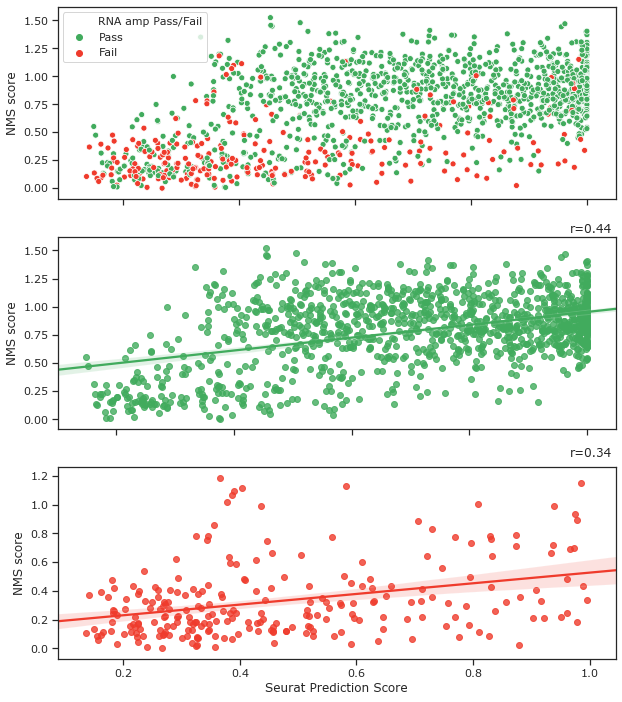

In [10]:
colors={"Pass": "#41ab5d", "Fail": "#ef3b2c"}
fig_dims = (10, 12)
f, axes = plt.subplots(nrows=3, ncols=1, figsize=fig_dims)

ax = sns.scatterplot(y="NMS score", x="seurat_prediction_score_label", data=shinyh,
                     palette=colors, hue="RNA amp Pass/Fail", ax=axes[0])

corr = pearsonr(shinyh_rpass["seurat_prediction_score_label"], shinyh_rpass["NMS score"])
corr = [np.round(c, 2) for c in corr]
text = f"r={corr[0]}"

ax1 = sns.regplot(y="NMS score", x="seurat_prediction_score_label", data=shinyh_rpass, color="#41ab5d", ax=axes[1])
ax.text(0.97, -0.4, text, fontsize=12)


corr = pearsonr(shinyh_rfail["seurat_prediction_score_label"], shinyh_rfail["NMS score"])
corr = [np.round(c, 2) for c in corr]
text = f"r={corr[0]}"

ax2 = sns.regplot(y="NMS score", x="seurat_prediction_score_label", data=shinyh_rfail, color="#ef3b2c", ax=axes[2])
ax.text(0.97, -2.4, text, fontsize=12)


ax.set(xticklabels=[])
ax1.set(xticklabels=[])
ax.set_xlabel("")
ax1.set_xlabel("")
ax2.set_xlabel("Seurat Prediction Score")

##### Countplot

In [11]:
shinyh_npass = filter_df(shinyh, "NMS Pass/Fail", True)
shinyh_nfail = filter_df(shinyh, "NMS Pass/Fail", False)
shinyh_rpass = filter_df(shinyh, "RNA amp Pass/Fail", "Pass")
shinyh_rfail = filter_df(shinyh, "RNA amp Pass/Fail", "Fail")
rfail_nfail = filter_df(shinyh_rfail, "NMS Pass/Fail", False)
rfail_npass = filter_df(shinyh_rfail, "NMS Pass/Fail", True)
rpass_nfail = filter_df(shinyh_rpass, "NMS Pass/Fail", False)
rpass_npass = filter_df(shinyh_rpass, "NMS Pass/Fail", True)
rfail_nfail["Group"] = "RNA Fail/NMS Fail"
rfail_npass["Group"] = "RNA Fail/NMS Pass"
rpass_nfail["Group"] = "RNA Pass/NMS Fail"
rpass_npass["Group"] = "RNA Pass/NMS Pass"

INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == True
INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == False
INFO:functions.temp_funcs:Filtered dataframe based on RNA amp Pass/Fail == Pass
INFO:functions.temp_funcs:Filtered dataframe based on RNA amp Pass/Fail == Fail
INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == False
INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == True
INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == False
INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == True
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__

In [12]:
count_rn = pd.concat([rfail_nfail, rfail_npass, rpass_nfail, rpass_npass])

In [13]:
count_rn.drop(columns=["sample_id", "cDNA quality (%>400 bp)", "RNA amp Pass/Fail",
                       "Amplified content (ng)", "NMS score", "NMS Pass/Fail", "seurat_prediction_score_label",
                       "collaborator_label"], inplace=True)

In [14]:
count_rn["Group_count"] = count_rn.groupby(["Group", "Tree_call"])["Tree_call"].transform("count")
count_rn["Group_total"] = count_rn.groupby("Group")["Tree_call"].transform("count")
count_rn["proportion"] = count_rn["Group_count"] / count_rn["Group_total"]

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [15]:
count_rn["Group_count"].unique()
count_rn["Group_total"].unique()

array([ 174,   69,  168, 1078], dtype=int64)

In [35]:
new_piv = pd.pivot_table(count_rn, values='proportion', index=["Group"], columns="Tree_call")
new_piv

In [76]:
#rfail_nfail.Tree_call.value_counts()
#rfail_npass.Tree_call.value_counts()
#rpass_nfail.Tree_call.value_counts()
rpass_npass.Tree_call.value_counts()

Core     537
I1       256
I2       186
PoorQ     91
I3         8
Name: Tree_call, dtype: int64

[Text(0, 0.5, 'Cell Proportion'), Text(0.5, 0, 'Groups')]

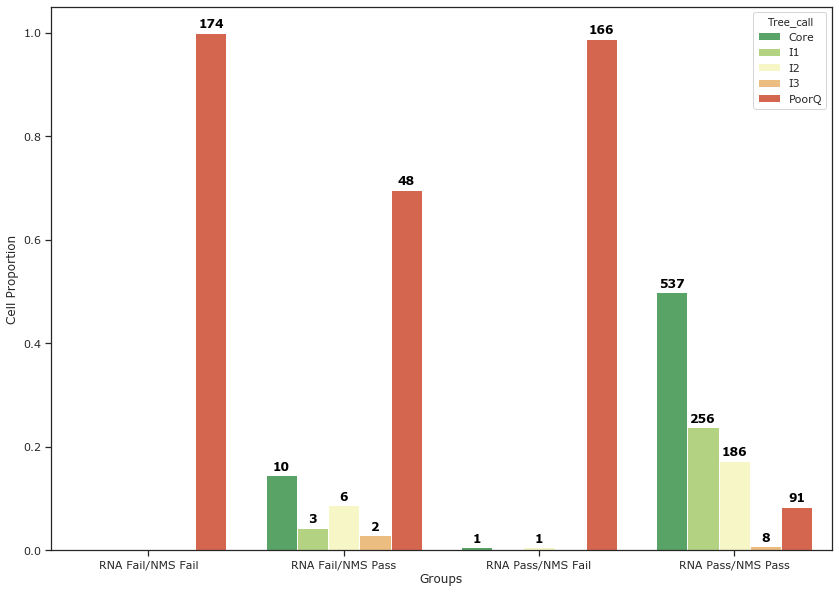

In [126]:
count_colors={"Core": "#41ab5d", "I1": "#2171b5", "I2": "#4292c6", "I3": "#6baed6", "PoorQ": "#ef3b2c"}

fig_dims = (14, 10)
f, axes = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x="Group", y="proportion", hue="Tree_call", data=count_rn, hue_order=count_colors, palette="RdYlGn_r")

core = [0, 10, 1, 537]
i1 = [0, 3, 0, 256]
i2 = [0, 6, 1, 186]
i3 = [0, 2, 0, 8]
poorq = [174, 48, 166, 91]
count_list = core + i1 + i2 + i3 + poorq

i=0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.01,
        count_list[i],ha="center", size="medium", color='black', weight='bold')
    i += 1

ax.set(xlabel="Groups", ylabel="Cell Proportion")

In [105]:
print(f"RNA Fail/NMS Fail: {rfail_nfail.sample_id.count()}")
print(f"RNA Fail/NMS Pass: {rfail_npass.sample_id.count()}")
print(f"RNA Pass/NMS Fail: {rpass_nfail.sample_id.count()}")
print(f"RNA Pass/NMS Pass: {rpass_npass.sample_id.count()}")

RNA Fail/NMS Fail: 174
RNA Fail/NMS Pass: 69
RNA Pass/NMS Fail: 168
RNA Pass/NMS Pass: 1078


In [106]:
print(f"Rpass total count: {shinyh_rpass.sample_id.count()}")
print(f"Rfail total count: {shinyh_rfail.sample_id.count()}")

Rpass total count: 1246
Rfail total count: 243


In [107]:
rfail_nfail.Tree_call.value_counts(normalize=True) #rfail_nfail["Tree_call"].value_counts() / rfail_nfail["Tree_call"].count()
rfail_npass.Tree_call.value_counts(normalize=True)
rpass_nfail.Tree_call.value_counts(normalize=True)
rpass_npass.Tree_call.value_counts(normalize=True)

Core     0.498145
I1       0.237477
I2       0.172542
PoorQ    0.084416
I3       0.007421
Name: Tree_call, dtype: float64

In [108]:
count_rn["Group"].value_counts() / count_rn["Group"].count()

RNA Pass/NMS Pass    0.723976
RNA Fail/NMS Fail    0.116857
RNA Pass/NMS Fail    0.112827
RNA Fail/NMS Pass    0.046340
Name: Group, dtype: float64

##### Filter project code

##### Counts

In [109]:
aibs = filter_df(shinyh, "collaborator_label", "AIBS")
pg = filter_df(shinyh, "collaborator_label", "Gabor")
ph = filter_df(shinyh, "collaborator_label", "Mansvelder")
print(f"Human total count: {shinyh.sample_id.count()}")
print(f"AIBS count: {aibs.sample_id.count()}")
print(f"Gabor count: {pg.sample_id.count()}")
print(f"Mansvelder count: {ph.sample_id.count()}")

INFO:functions.temp_funcs:Filtered dataframe based on collaborator_label == AIBS
INFO:functions.temp_funcs:Filtered dataframe based on collaborator_label == Gabor
INFO:functions.temp_funcs:Filtered dataframe based on collaborator_label == Mansvelder


Human total count: 1489
AIBS count: 1489
Gabor count: 0
Mansvelder count: 0
